# Evaluating the model on test dataset
This notebook evaluates the trained model on the test dataset using **Normalized Mean Squared Error (NMSE)** metrics.

In [1]:
import numpy as np
import time, os
import matplotlib.pyplot as plt
import torch

from neoradium import Carrier, PDSCH, CdlChannel, AntennaPanel, Grid, random, LdpcEncoder

from ChEstNet import ChEstNet, ChEstDataset
from ChEstUtils import toComplex

In [2]:
# Load the model:
modelPath = 'Models/BestModel.pth'
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = ChEstNet(device)                                # Instantiate the model on the target device
model.loadParams(modelPath);                            # Load the trained model parameters

numGood: 0         1         2         3
MSE:     0.412409  0.121682  0.059642  0.042878
MAE:     0.553360  0.288852  0.210743  0.179124
NMSE:    0.291761  0.088112  0.042711  0.030690



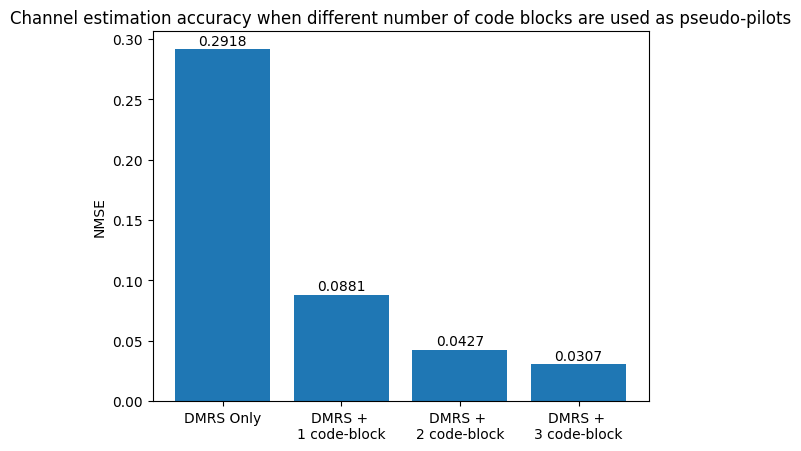

In [3]:
# Evaluate the model on the test dataset
dataPath = "/data/datasets/SelfRefine/"                     # Replace with the location of your data files
testDS = ChEstDataset( os.path.join(dataPath,"Test.npy") )  # Create the test dataset

numCBs = len(testDS.numPilots)
sumMAEs = np.zeros(numCBs, dtype=np.float64)
sumMSEs = np.zeros(numCBs, dtype=np.float64)
sumNMSEs = np.zeros(numCBs, dtype=np.float64)
counts = np.zeros(numCBs, dtype=np.int32)

model.eval()                                # Set the model to evaluation mode
with torch.no_grad():
    for batchSamples, batchLabels in testDS.batches(device):
        samples = toComplex(batchSamples.cpu().numpy())[:,:-1,:,:]   
        actuals = toComplex(batchLabels.cpu().numpy())
        preds = toComplex( model( batchSamples ).cpu().numpy() )
        for sample, actual, pred in zip(samples, actuals, preds):
            pilotIdx = np.where(sample.real!=0)
            assert len(pilotIdx[0]) in testDS.numPilots, "%d - %d\n"%(len(pilotIdx[0]), sum(counts))
            numGoodCBs = testDS.numPilots.index(len(pilotIdx[0]))

            absoluteErrors = np.abs(pred-actual)
            sumMAEs[numGoodCBs] += absoluteErrors.mean()
            sumMSEs[numGoodCBs] += np.square(absoluteErrors).mean()
            sumNMSEs[numGoodCBs]+= np.square(absoluteErrors).sum()/np.square(np.abs(actual-actual.mean())).sum()
            counts[numGoodCBs] += 1

mses, maes, nmses= sumMSEs/counts, sumMAEs/counts, sumNMSEs/counts
print(f"numGood: 0         1         2         3" )
print(f"MSE:     {mses[0]:.6f}  {mses[1]:.6f}  {mses[2]:.6f}  {mses[3]:.6f}" )
print(f"MAE:     {maes[0]:.6f}  {maes[1]:.6f}  {maes[2]:.6f}  {maes[3]:.6f}" )
print(f"NMSE:    {nmses[0]:.6f}  {nmses[1]:.6f}  {nmses[2]:.6f}  {nmses[3]:.6f}\n" )

rects = plt.bar(['DMRS Only', 'DMRS + \n1 code-block', 'DMRS + \n2 code-block', 'DMRS + \n3 code-block'], nmses)
plt.bar_label(rects, padding=1, fmt='%6.4f', fontsize=10)
plt.title("Channel estimation accuracy when different number of code blocks are used as pseudo-pilots");
plt.ylabel("NMSE")
plt.show()